In [1]:
import os 
import sys
import re 

import pandas as pd
import numpy as np


# geospatial 
from gerrychain import Graph
import geopandas as gpd
import networkx as nx

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
from scipy import stats

# Rc Params
custom_rc = {
    # font general
    'font.family': 'Times New Roman',

    # ticks
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.labelsize': 14,


    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.labelsize': 12,


    # title
    'axes.titlesize': 18,
    'axes.titleweight': 'bold', 
    'axes.titlecolor': 'black', 

    # axes
    'axes.labelsize': 16,
    'axes.labelweight': 'normal',  
    'axes.labelcolor': 'black',      

    # legend
    'legend.fontsize': 14,  
}

mpl.rcParams.update(custom_rc)

###### outDir ######
outDir = "../figs/elections"
os.makedirs(outDir, exist_ok=True)

###### Load Data ######
results_df = pd.read_csv('../dataOut/election_metrics.csv')
# color code winner 
results_df["Winner"] = results_df["Winner"].apply(lambda x: 'blue' if x == "Democrat" else 'red') # bool flag for democrat win

gdf = gpd.read_file('../dataIn/elections/shapefiles/US_county_2020.shp')
gdf.set_index("GISJOIN", drop = True, inplace = True)

## **Query Data** 

- Remove states who's BVAP < mean

In [2]:
"""
Query by BVAP%
  - f"`BVAP%` > {mean}"
"""

col1 = "v"
col2 = "w1"
colorKey = "BVAP%"

mean = results_df[colorKey].describe().get("mean")
median = results_df[colorKey].median()

query_str = f"`BVAP%` > {mean}"


plot_df = results_df.query(query_str).copy()
plot_df.head()

,[StateFP][ElectionYear],State,StateFP,Election_Year,w,w1,v,mvc,l1,l1w,...,linf,linfw,r,r^2,BVAP%,Dem%,REP%,Votes,VAP,Winner
0,482000,Texas,48,2000,0.430731,2.592206,0.014176,0.325931,67.117461,0.264242,...,0.773962,0.003047,0.173609,0.030140,13.029443,37.981958,59.298599,6407637,18578830,red
1,482004,Texas,48,2004,0.385406,2.548228,0.013506,0.321440,58.595791,0.230692,...,0.743589,0.002928,0.228178,0.052065,13.029443,38.224260,61.085823,7410749,18578830,red
2,482008,Texas,48,2008,0.482466,2.702160,0.015958,0.421040,62.744125,0.247024,...,0.844335,0.003324,0.104491,0.010918,13.029443,43.683121,55.452360,8077795,18578830,red
3,482012,Texas,48,2012,0.500909,2.624320,0.015879,0.453384,54.363558,0.214030,...,0.862778,0.003397,0.089062,0.007932,13.029443,41.383358,57.166977,7993851,18578830,red
4,482016,Texas,48,2016,0.428717,2.566622,0.015497,0.464772,47.361260,0.186462,...,0.790586,0.003113,0.075331,0.005675,13.029443,43.235258,52.234686,8969226,18578830,red


## **Fig. 5  - Scatterplot** 

### **Plot Function** 

In [3]:
###############
## Main Function
###############
def paper_scatterplot(ax, x, y, z, masks: dict, label_config: dict, colorbar_config: dict):

    if "title" in label_config.keys():
        title = label_config["title"]
    else:
        title = ""

    x_label = label_config["x_label"]
    y_label = label_config["y_label"]

    cmin, cmax, colorbar_title, cmap = colorbar_config["cmin"], colorbar_config["cmax"], colorbar_config["colorbar_title"], colorbar_config["cmap"]

    # linear regression
    slope, intercept, _, _, _ = stats.linregress(x, y)
    x_fit, y_fit = np.linspace(np.min(x), np.max(x), 100), intercept + slope * np.linspace(np.min(x),np.max(x),100)
    ax.plot(x_fit, y_fit, '--', label='Fitted line', color='black', linewidth = 1.5, zorder = 2)

    # scatterplot points
    for label, mask in masks.items():
        sc = ax.scatter(
        x[mask],
        y[mask],
        c=z[mask],
        cmap=cmap,
        s=12,
        vmin=cmin,
        vmax=cmax,
        edgecolor='k',
        linewidth=0.5,
        label=label
    )   


    ax.set_title(f'{title}')
    ax.set_xlabel(f'{x_label}')
    ax.set_ylabel(f'{y_label}')
    fig = ax.get_figure()
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label(f"{colorbar_title}")

    return ax

def name_point(xish,yish, data):
    xmin ,xmax = xish-.5, xish + 0.5
    ymin, ymax = yish-.5, yish + 0.5

    indices = np.where(
            (data[:,:,0] >=xmin) & (data[:,:,0] <= xmax) &
            (data[:,:,1] >=ymin) & (data[:,:,1] <= ymax)
    )
    s = [list(df.index)[indices[0][i]] for i in range(len(indices[0]))]
    e = [i for i in range(len(indices[1]))]
    return list(zip(s, e))


### **Plot and Save** 

#### **2b1**

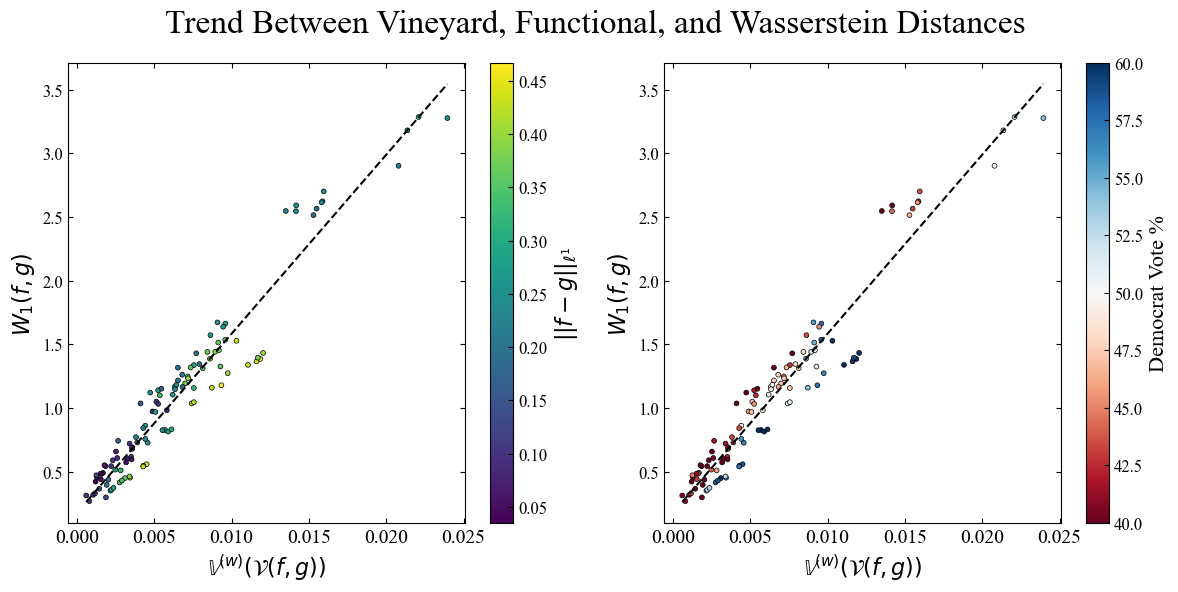

In [4]:
# main plot 
fig, ax = plt.subplots(1,2, figsize = (12,6))

# (left) - weighted l1 distance
x = plot_df["v"]
y = plot_df["w1"]
z = plot_df["l1w"]

democrat_mask = plot_df["Winner"] == "Democrat"
masks = {
    "Democrat" : democrat_mask, 
    "Republican" : ~democrat_mask
}
label_config = {
    "x_label" : r"$\mathbb{V}^{(w)}(\mathcal{V}(f,g))$",
    "y_label" : r'$W_1(f,g)$',
}

colorbar_config = {
    "cmin": plot_df["l1w"].min(),
    "cmax": plot_df["l1w"].max(),
    # "colorbar_title" : r"Weighted $\ell^1$",
    "colorbar_title" : r"$||f-g||_{\ell^1}$",
    "cmap" : "viridis"
}

paper_scatterplot(ax[0], x, y, z, masks, label_config, colorbar_config)

## (right) - Democrat votershare
x = plot_df["v"]
y = plot_df["w1"]
z = plot_df["Dem%"]

democrat_mask = plot_df["Winner"] == "Democrat"
masks = {
    "Democrat" : democrat_mask, 
    "Republican" : ~democrat_mask
}

colorbar_config = {
    "cmin": 40.0,
    "cmax": 60.0,
    "colorbar_title" : "Democrat Vote %",
    "cmap" : "RdBu"
}
paper_scatterplot(ax[1], x, y, z, masks, label_config, colorbar_config)


fig.suptitle(r"Trend Between Vineyard, Functional, and Wasserstein Distances",
            fontfamily = "Times New Roman",
            fontsize = 24,
            fontweight = "normal",
            color = "black")


plt.tight_layout()

plt.savefig("../figs/elections/scatterplot_1b2.png")
plt.show()

#### **l1_only**

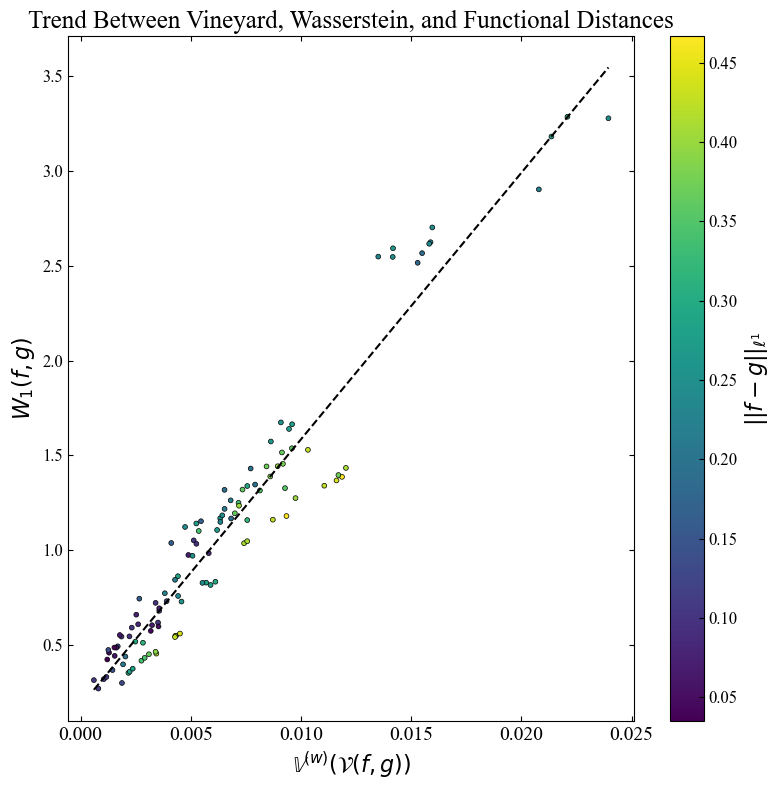

In [5]:
# main plot 
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax = [ax]

# (left) - weighted l1 distance
x = plot_df["v"]
y = plot_df["w1"]
z = plot_df["l1w"]

democrat_mask = plot_df["Winner"] == "Democrat"
masks = {
    "Democrat" : democrat_mask, 
    "Republican" : ~democrat_mask
}
label_config = {
    "x_label" : r"$\mathbb{V}^{(w)}(\mathcal{V}(f,g))$",
    "y_label" : r'$W_1(f,g)$',
}

colorbar_config = {
    "cmin": plot_df["l1w"].min(),
    "cmax": plot_df["l1w"].max(),
    # "colorbar_title" : r"Weighted $\ell^1$",
    "colorbar_title" : r"$||f-g||_{\ell^1}$",
    "cmap" : "viridis"
}

paper_scatterplot(ax[0], x, y, z, masks, label_config, colorbar_config)
ax[0].set_title("Trend Between Vineyard, Wasserstein, and Functional Distances", fontfamily = "Times New Roman", fontsize = 18, fontweight = "normal", color = "black")


plt.tight_layout()

plt.savefig("../figs/elections/scatterplot_l1_only.png")
plt.show()

#### **dem_only**

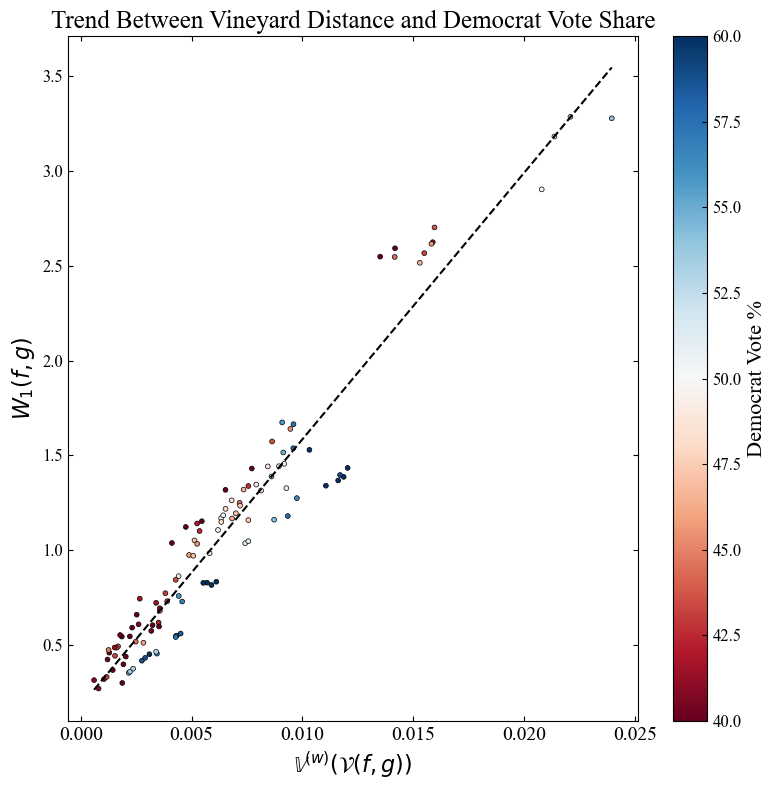

In [6]:
# main plot 
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax = [ax]

# (left) - weighted l1 distance
x = plot_df["v"]
y = plot_df["w1"]
z = plot_df["Dem%"]

democrat_mask = plot_df["Winner"] == "Democrat"
masks = {
    "Democrat" : democrat_mask, 
    "Republican" : ~democrat_mask
}

colorbar_config = {
    "cmin": 40.0,
    "cmax": 60.0,
    "colorbar_title" : "Democrat Vote %",
    "cmap" : "RdBu"
}

paper_scatterplot(ax[0], x, y, z, masks, label_config, colorbar_config)
ax[0].set_title("Trend Between Vineyard Distance and Democrat Vote Share", fontfamily = "Times New Roman", fontsize = 18, fontweight = "normal", color = "black")


plt.tight_layout()

plt.savefig("../figs/elections/scatterplot_dem_only.png")
plt.show()

## **Fig. 6 - Virginia 2020** 

### **Plot Function** 

In [7]:
###############
## Main Function
###############
def plot_state_election(G, gdf, col: str, label_config: dict, colorbar_config: dict, ax = None): 

    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = (8,8))
    
    # f function
    f = [nx.get_node_attributes(G, f"{col}")[n] for n in G.nodes()] 

    # Join graph data to gdf
    GISJOINS = [nx.get_node_attributes(G, "GISJOIN")[n] for n in G.nodes()]
    # slice gdf by state and convert ratio to percent
    state_gdf = gdf.loc[GISJOINS]
    state_gdf['f'] = f 
    state_gdf['f'] *= 100

    # plot
    state_gdf.plot(column=state_gdf['f'], 
               cmap= colorbar_config['cmap'] , # RdBu
               vmin = 0, 
               vmax = 100, # min(state_gdf['f'].max(), 1), 
               ax=ax, 
               legend=True, 
               legend_kwds={'shrink': 0.75},
               edgecolor='k',
               linewidth=0.5) 
    
    # colorbar legend
    cbar = ax.get_figure().axes[-1]
    cbar.set_ylabel(f"{colorbar_config['colorbar_title']}")

    # axis and title
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_title(f"{label_config['title']}")

    return ax   

###############
## Annotation Helpers
###############

def get_county_coord(county, gdf):
    county_geom = gdf[gdf["NAME"] == f"{county}"].geometry.centroid.values[0]
    county_x, county_y = county_geom.x, county_geom.y
    return county_x, county_y

def get_county_annotation_dict(counties_to_annotate, gdf, G):
    name_to_node = {attr["NAME"]: n for n, attr in G.nodes(data=True) if "NAME" in attr}
    nodes = [name_to_node[name] for name in counties_to_annotate]

    bvap_values = [G.nodes[node].get("BVAP") * 100 for node in nodes] 
    dem_values = [G.nodes[node].get("2020_D") * 100 for node in nodes] 

    coordinate_values = [get_county_coord(county, gdf) for county in counties_to_annotate]

    annotation_dict = {
        f"{county}": {
            "BVAP": bvap_values[i],
            "DEM": dem_values[i],
            "x": coordinate_values[i][0],
            "y": coordinate_values[i][1]
        } for i, county in enumerate(counties_to_annotate)
    }

    return annotation_dict

def annotate_gdf(annotation_dict, ax):
    for annotation_name, data in annotation_dict.items():
        x, y = data["x"], data["y"]
        ax.annotate(
        text=f"{annotation_name}", 
        xy=(x - 7500, y + 5000), 
        xytext=(x + 8500, y + 21000),
        textcoords='data',
        arrowprops=dict(arrowstyle='-', color='black', linewidth=0.75),
        fontsize=12,
        bbox=dict(boxstyle='square,pad=0.3', fc='white', ec='black', lw=0.5)
    )
    return ax
    

### **Plot and Save** 

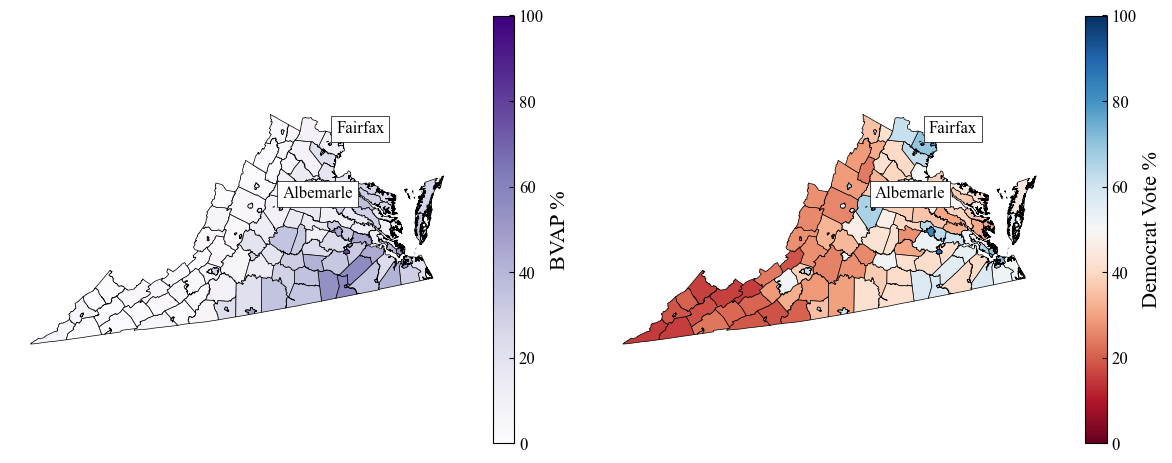

In [8]:
state = "Virginia"
election = "2020"
col1 = "BVAP"
col2 = f"{election}_D"

G = Graph.from_json(f"../dataIn/elections/state_graphs_2020/{state.replace(' ', '_')}.json")


fig, axs = plt.subplots(1,2, figsize = (12, 6)) 

# BVAP Plot
col1 = "BVAP"
colorbar_config = {
    "colorbar_title" : "BVAP %",
    "cmap" : "Purples"
}
label_config = {
    "title" : ""
}
plot_state_election(G, gdf, col1, label_config, colorbar_config, ax = axs[0])
# Dem % Plot
col2 = f"{election}_D"
colorbar_config = {
    "colorbar_title" : "Democrat Vote %",
    "cmap" : "RdBu"
}
label_config = {
    "title" : ""
}

counties_to_annotate = ['Albemarle', 'Fairfax']
annotation_dict = get_county_annotation_dict(counties_to_annotate, gdf, G)

annotate_gdf(annotation_dict, axs[0])
annotate_gdf(annotation_dict, axs[1])

plot_state_election(G, gdf, col2, label_config, colorbar_config, ax = axs[1])

plt.tight_layout()

plt.savefig("../figs/elections/VA_2020.png")

plt.show()

### **Compare Data**

In [9]:
###############
## Compare Regression to True Value
###############

col1 = "v"
col2 = "w1"
state = "Virginia"
election = 2020

# query df
colorKey = "BVAP%"

mean = results_df[colorKey].describe().get("mean")
query_str = f"`BVAP%` > {mean}"
plot_df = results_df[results_df["Election_Year"] == 2020].query(query_str).copy()

state_x = plot_df[plot_df["State"] == state][col1].values
state_y = plot_df[plot_df["State"] == state][col2].values
state_mvc = plot_df[plot_df["State"] == state]["mvc"].values
x, y = plot_df[col1], plot_df[col2]
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

y_fit = state_x * slope + intercept
x_fit = (state_y - intercept) / slope
print(f"{col1} : {state_x}", f"fitted {col1}: {x_fit}")
print(f"ratio : {state_x / x_fit}")
print(f"mvc ratio: {abs(state_x - x_fit) / state_mvc}")

v : [0.02395131] fitted v: [0.02293813]
ratio : [1.04417008]
mvc ratio: [0.00179654]
